In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install japanize_matplotlib
! pip install xfeat
! pip install category-encoders

     |████████████████████████████████| 4.1 MB 4.1 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=3543e98d84fc8eeae2ff46763065110b52fb0d50782ea599736237592c31f497
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib
     |████████████████████████████████| 302 kB 6.7 MB/s 
     |████████████████████████████████| 80 kB 6.4 MB/s 
     |████████████████████████████████| 208 kB 67.3 MB/s 
     |████████████████████████████████| 75 kB 3.2 MB/s 
     |████████████████████████████████| 111 kB 57.6 MB/s 
     |████████████████████████████████| 49 kB 4.5 MB/s 
     |████████████████████████████████| 144 kB 66.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=de7e39cdee5a9daa5c3223858d7ea94527254b9b73db8267888d6d899bdf57dc
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b0

# 1.必要モジュールの読み込み

In [3]:
## import module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from matplotlib_venn import venn2
import os
from statistics import mode
from scipy.optimize import minimize, minimize_scalar
from scipy.misc import derivative
import random
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import BorderlineSMOTE

import missingno as msno

from IPython.display import Image

from sklearn.model_selection import KFold, StratifiedKFold
import category_encoders as ce
from xfeat import (SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, 
                   ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer)
from sklearn import preprocessing
from time import time
from contextlib import contextmanager
import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
class CFG:
  exp = "exp24"
  seed = 71
  fold = 5

CONFIG = CFG()

In [5]:
input_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/data/"
output_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/output/"

# 2.データフレームの形状変換

In [6]:
pd.set_option("display.max_colwidth", 300)

# Import file
df1 = pd.read_csv(input_dir + "gi_train_mm10.csv")
df2 = pd.read_csv(input_dir + "gi_train_mm11.csv")
df_test = pd.read_csv(input_dir + "gi_test.csv")
sample_submit = pd.read_csv(input_dir + "gi_sample_submit.csv")
df_train = pd.concat([df1,df2]).reset_index(drop=True)

df_train = df_train[~df_train.customer_id.isnull()].reset_index()

In [7]:
df_train = df_train[['customer_id',
                     'event_day', 
                     #'store_id', 
                     #'store',
                     #'project_category',
                     'area_id',
                     'gender', 
                     'age', 
                     'age_category',
                     'event_type',
                     'product_id', 
                     'product_name', 
                     'company', 
                     'time_duration',
                     'num_touch', 
                     'in_time',
                     'out_time', 
                     'buy_flag']]

df_test = df_test[['customer_id',
                     'event_day', 
                     #'store_id', 
                     #'store',
                     #'project_category',
                     'area_id',
                     'gender', 
                     'age', 
                     'age_category',
                     'event_type',
                     'product_id', 
                     'product_name', 
                     'company', 
                     'time_duration',
                     'num_touch',
                     'in_time',
                     'out_time']]

In [8]:
df_train =df_train.copy()
df_test =df_test.copy()

df_train["in_time"]=pd.to_datetime(df_train["in_time"])
df_train["out_time"]=pd.to_datetime(df_train["out_time"])
df_test["in_time"]=pd.to_datetime(df_test["in_time"])
df_test["out_time"]=pd.to_datetime(df_test["out_time"])

In [9]:
df_train1 = df_train[df_train.event_type ==1].reset_index(drop=True)
df_train2 = df_train[df_train.event_type ==2].reset_index(drop=True)
df_train3 = df_train[df_train.event_type ==3].reset_index(drop=True)

df_test1 = df_test[df_test.event_type ==1].reset_index(drop=True)
df_test2 = df_test[df_test.event_type ==2].reset_index(drop=True)
df_test3 = df_test[df_test.event_type ==3].reset_index(drop=True)

In [10]:
df_train_0=df_train[df_train.event_type !=3].reset_index(drop=True)
df_test_0=df_test[df_test.event_type !=3].reset_index(drop=True)

In [11]:
df_train4 = pd.merge(df_train3,df_train1[["customer_id","in_time","out_time"]],on="customer_id")
df_train4=df_train4.rename(columns={"in_time_x":"in_time_3","out_time_x":"out_time_3","in_time_y":"in_time_1","out_time_y":"out_time_1"})

df_train4["1in_3in"]=df_train4["in_time_3"]-df_train4["in_time_1"]
df_train4["1in_3in"] = df_train4["1in_3in"].apply(lambda x: x.seconds)
df_train4["3in_1out"]=df_train4["out_time_1"]-df_train4["in_time_3"]
df_train4["3in_1out"] = df_train4["3in_1out"].apply(lambda x: x.seconds)

df_test4 = pd.merge(df_test3,df_test1[["customer_id","in_time","out_time"]],on="customer_id")
df_test4=df_test4.rename(columns={"in_time_x":"in_time_3","out_time_x":"out_time_3","in_time_y":"in_time_1","out_time_y":"out_time_1"})

df_test4["1in_3in"]=df_test4["in_time_3"]-df_test4["in_time_1"]
df_test4["1in_3in"] = df_test4["1in_3in"].apply(lambda x: x.seconds)
df_test4["3in_1out"]=df_test4["out_time_1"]-df_test4["in_time_3"]
df_test4["3in_1out"] = df_test4["3in_1out"].apply(lambda x: x.seconds)

## 2-1.Customer_IDごとの各特徴量の整理

In [12]:
# base
df_train4 = df_train4.drop(columns=["event_type","product_id","time_duration","num_touch","area_id"])
df_test4 = df_test4.drop(columns=["event_type","product_id","time_duration","num_touch","area_id"])

#shopper frame time
df_frametime_train=df_train1[["customer_id","time_duration"]].drop_duplicates()
df_frametime_train.columns=["customer_id","time_duration_frame"]
df_frametime_test=df_test1[["customer_id","time_duration"]].drop_duplicates()
df_frametime_test.columns=["customer_id","time_duration_frame"]

# shopper area time
df_sub=df_train[df_train.event_type !=1].sort_values(["customer_id","event_type"]).reset_index(drop=True)
df_sub["time_duration"] =df_sub["time_duration"].replace(0,None) 
df_sub["area_id"]=df_sub["area_id"].fillna(method='ffill')
df_sub["time_duration"]=df_sub["time_duration"].fillna(method='ffill')
df_area_train = df_sub[~df_sub.num_touch.isnull()]
df_area_train =df_area_train.drop_duplicates()
df_area_train = df_area_train[["customer_id","area_id","time_duration"]]
df_area_train.columns=["customer_id","area_id","time_duration_area"]

df_sub=df_test[df_test.event_type !=1].sort_values(["customer_id","event_type"]).reset_index(drop=True)
df_sub["time_duration"] =df_sub["time_duration"].replace(0,None) 
df_sub["area_id"]=df_sub["area_id"].fillna(method='ffill')
df_sub["time_duration"]=df_sub["time_duration"].fillna(method='ffill')
df_area_test = df_sub[~df_sub.num_touch.isnull()]
df_area_test =df_area_test.drop_duplicates()
df_area_test = df_area_test[["customer_id","area_id","time_duration"]]
df_area_test.columns=["customer_id","area_id","time_duration_area"]

In [13]:
df_train = pd.merge(df_train4,df_frametime_train,on="customer_id")
df_train = pd.merge(df_train,df_area_train,on="customer_id")
df_train = df_train.drop_duplicates()

df_test = pd.merge(df_test4,df_frametime_test,on="customer_id")
df_test = pd.merge(df_test,df_area_test,on="customer_id")
df_test = df_test.drop_duplicates()

In [14]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,company,in_time_3,out_time_3,buy_flag,in_time_1,out_time_1,1in_3in,3in_1out,time_duration_frame,area_id,time_duration_area
0,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,2021-09-25 08:01:51.400,NaT,1.0,2021-09-25 08:01:50.200,2021-09-25 08:01:56.400,1,5,6.2,1.0,6.2
2,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,2021-09-25 08:01:53.600,NaT,1.0,2021-09-25 08:01:50.200,2021-09-25 08:01:56.400,3,2,6.2,1.0,6.2
4,20201026-010002,2020/10/26,man,50's,Middle,クリアブラウン525ml,クオリティー,2021-09-25 08:02:50.400,NaT,1.0,2021-09-25 08:02:43.600,2021-09-25 08:02:57.200,6,6,13.6,1.0,7.8
6,20201026-010002,2020/10/26,man,50's,Middle,トラディショナル緑茶525ml,クオリティー,2021-09-25 08:02:54.200,NaT,1.0,2021-09-25 08:02:43.600,2021-09-25 08:02:57.200,10,3,13.6,1.0,7.8
8,20201026-010003,2020/10/26,man,50's,Middle,桃の世界410ml,フューチャー,2021-09-25 08:03:00.400,NaT,1.0,2021-09-25 08:02:57.800,2021-09-25 08:03:12.000,2,11,14.2,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26416,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,エターナル,2021-09-25 21:38:20.200,NaT,0.0,2021-09-25 21:38:07.200,2021-09-25 21:38:35.600,13,15,28.4,1.0,11.2
26419,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,2021-09-25 21:38:20.800,NaT,0.0,2021-09-25 21:38:07.200,2021-09-25 21:38:35.600,13,14,28.4,1.0,11.2
26422,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,2021-09-25 21:38:21.200,NaT,1.0,2021-09-25 21:38:07.200,2021-09-25 21:38:35.600,14,14,28.4,1.0,11.2
26425,20201101-120055,2020/11/1,woman,30's,Young,ジャパンスプラッシュ500ml,クオリティー,2021-09-25 21:39:33.800,NaT,0.0,2021-09-25 21:39:27.400,2021-09-25 21:39:41.400,6,7,14.0,5.0,13.0


In [15]:
df_train = pd.merge(df_train,df_train2[["customer_id","in_time","out_time","area_id"]],on=["customer_id","area_id"])
df_train=df_train.rename(columns={"in_time":"in_time_2","out_time":"out_time_2"})

df_train["3in_2in"]=df_train["in_time_3"]-df_train["in_time_2"]
df_train["3in_2in"] = df_train["3in_2in"].apply(lambda x: x.seconds)
df_train["3in_2out"]=df_train["out_time_2"]-df_train["in_time_3"]
df_train["3in_2out"] = df_train["3in_2out"].apply(lambda x: x.seconds)

df_train=df_train.drop(columns=["in_time_2","in_time_3","out_time_1","out_time_2","out_time_3"])
#df_train = df_train.reindex(columns=['customer_id', 'event_day', 'gender', 'age', 'age_category','product_name', 'company', 'area_id', '1in_3in', '3in_1out', '3in_2in', '3in_2out','time_duration_frame','time_duration_area', 'in_time_1', 'buy_flag'])
df_train = df_train.reindex(columns=['customer_id', 'event_day', 'gender', 'age', 'age_category','product_name', 'company', 'area_id', '1in_3in', '3in_1out','time_duration_frame','time_duration_area', 'in_time_1', 'buy_flag'])


df_test = pd.merge(df_test,df_test2[["customer_id","in_time","out_time","area_id"]],on=["customer_id","area_id"])
df_test=df_test.rename(columns={"in_time":"in_time_2","out_time":"out_time_2"})

df_test["3in_2in"]=df_test["in_time_3"]-df_test["in_time_2"]
df_test["3in_2in"] = df_test["3in_2in"].apply(lambda x: x.seconds)
df_test["3in_2out"]=df_test["out_time_2"]-df_test["in_time_3"]
df_test["3in_2out"] = df_test["3in_2out"].apply(lambda x: x.seconds)

df_test=df_test.drop(columns=["in_time_2","in_time_3","out_time_1","out_time_2","out_time_3"])
df_test = df_test.reindex(columns=['customer_id', 'event_day', 'gender', 'age', 'age_category','product_name', 'company', 'area_id', '1in_3in', '3in_1out','time_duration_frame','time_duration_area', 'in_time_1'])

In [16]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time_1,buy_flag
0,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,1,5,6.2,6.2,2021-09-25 08:01:50.200,1.0
1,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,3,2,6.2,6.2,2021-09-25 08:01:50.200,1.0
2,20201026-010002,2020/10/26,man,50's,Middle,クリアブラウン525ml,クオリティー,1.0,6,6,13.6,7.8,2021-09-25 08:02:43.600,1.0
3,20201026-010002,2020/10/26,man,50's,Middle,トラディショナル緑茶525ml,クオリティー,1.0,10,3,13.6,7.8,2021-09-25 08:02:43.600,1.0
4,20201026-010003,2020/10/26,man,50's,Middle,桃の世界410ml,フューチャー,1.0,2,11,14.2,14.0,2021-09-25 08:02:57.800,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7785,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,エターナル,1.0,13,15,28.4,11.2,2021-09-25 21:38:07.200,0.0
7786,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,13,14,28.4,11.2,2021-09-25 21:38:07.200,0.0
7787,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,14,14,28.4,11.2,2021-09-25 21:38:07.200,1.0
7788,20201101-120055,2020/11/1,woman,30's,Young,ジャパンスプラッシュ500ml,クオリティー,5.0,6,7,14.0,13.0,2021-09-25 21:39:27.400,0.0


In [17]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time_1
0,20201026-010006,2020/10/26,man,40's,Middle,クリアブラウン525ml,クオリティー,1.0,8,11,19.8,7.2,2021-09-25 08:07:13.000
1,20201026-010006,2020/10/26,man,40's,Middle,クリアブラウン525ml,クオリティー,1.0,10,9,19.8,7.2,2021-09-25 08:07:13.000
2,20201026-010008,2020/10/26,man,40's,Middle,職人の力500ml,フューチャー,1.0,8,12,21.2,4.8,2021-09-25 08:10:32.600
3,20201026-010008,2020/10/26,man,40's,Middle,職人の力500ml,フューチャー,1.0,9,11,21.2,4.8,2021-09-25 08:10:32.600
4,20201026-010008,2020/10/26,man,40's,Middle,トラディショナル緑茶525ml,クオリティー,1.0,12,8,21.2,4.8,2021-09-25 08:10:32.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4843,20201101-120052,2020/11/1,man,20's,Young,優しい君500ml,ラボラトリー,2.0,9,19,28.6,16.8,2021-09-25 21:36:35.800
4844,20201101-120052,2020/11/1,man,20's,Young,ほっと一息500ml,エターナル,2.0,11,16,28.6,16.8,2021-09-25 21:36:35.800
4845,20201101-120052,2020/11/1,man,20's,Young,職人の力500ml,フューチャー,2.0,21,6,28.6,16.8,2021-09-25 21:36:35.800
4846,20201101-120056,2020/11/1,woman,30's,Young,匠の果実500ml,エターナル,1.0,15,7,22.6,15.2,2021-09-25 21:47:14.200


In [18]:
df_train[df_train["customer_id"]=="20201101-110130"]

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time_1,buy_flag
7717,20201101-110130,2020/11/1,man,30's,Young,本当のオレンジ490ml,フューチャー,3.0,11,31,43.0,33.6,2021-09-25 20:27:12.200,0.0
7718,20201101-110130,2020/11/1,man,30's,Young,本当のオレンジ490ml,フューチャー,3.0,28,15,43.0,33.6,2021-09-25 20:27:12.200,0.0
7719,20201101-110130,2020/11/1,man,30's,Young,本当のオレンジ490ml,フューチャー,3.0,30,13,43.0,33.6,2021-09-25 20:27:12.200,1.0


In [19]:
df_train.buy_flag.value_counts()

1.0    5417
0.0    2373
Name: buy_flag, dtype: int64

# 3.前処理

## 3-1.容量のカラム追加

In [20]:
size_train=df_train.product_name.str.extract(r'(\d\d\d)').astype(int)
df_train.insert(loc = 6, column= 'size', value= size_train)

size_test=df_test.product_name.str.extract(r'(\d\d\d)').astype(int)
df_test.insert(loc = 6, column= 'size', value= size_test)

In [21]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time_1,buy_flag
0,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,6.2,2021-09-25 08:01:50.200,1.0
1,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,6.2,2021-09-25 08:01:50.200,1.0
2,20201026-010002,2020/10/26,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.6,7.8,2021-09-25 08:02:43.600,1.0
3,20201026-010002,2020/10/26,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,7.8,2021-09-25 08:02:43.600,1.0
4,20201026-010003,2020/10/26,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.2,14.0,2021-09-25 08:02:57.800,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7785,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,525,エターナル,1.0,13,15,28.4,11.2,2021-09-25 21:38:07.200,0.0
7786,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,13,14,28.4,11.2,2021-09-25 21:38:07.200,0.0
7787,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,14,14,28.4,11.2,2021-09-25 21:38:07.200,1.0
7788,20201101-120055,2020/11/1,woman,30's,Young,ジャパンスプラッシュ500ml,500,クオリティー,5.0,6,7,14.0,13.0,2021-09-25 21:39:27.400,0.0


## 3-2.入時間の設定

In [22]:
#エントリータイムの時間を抽出
df_train["in_time_1"] = pd.to_datetime(df_train["in_time_1"])
df_train["in_time_hour"] = df_train["in_time_1"].apply(lambda x: x.hour)
df_train=df_train.drop(columns="in_time_1")

df_test["in_time_1"] = pd.to_datetime(df_test["in_time_1"])
df_test["in_time_hour"] = df_test["in_time_1"].apply(lambda x: x.hour)
df_test=df_test.drop(columns="in_time_1")

#曜日
df_train["event_day"] = pd.to_datetime(df_train["event_day"])
df_train["event_day"] = df_train["event_day"].apply(lambda x: x.weekday())

df_test["event_day"] = pd.to_datetime(df_test["event_day"])
df_test["event_day"] = df_test["event_day"].apply(lambda x: x.weekday())

## 3-3.滞在時間での切り捨て

In [25]:
df_train.groupby("buy_flag").time_duration_frame.mean()

buy_flag
0.0    106.510072
1.0     52.613144
Name: time_duration_frame, dtype: float64

In [26]:
def time_duration_revise(x,col):
  if x >= 500:
    x=df_test[col].mean()
    return x
  else:
    return x

In [27]:
#外れ値保管
df_test["1in_3in"]=df_test["1in_3in"].apply(lambda x:time_duration_revise(x,"1in_3in"))
df_test["3in_1out"]=df_test["3in_1out"].apply(lambda x:time_duration_revise(x,"3in_1out"))
df_train=df_train[df_train["3in_1out"] < 500].reset_index(drop=True)

#Frame time cut for positive
del_df_train = df_train[(df_train.time_duration_frame > 100) & (df_train.buy_flag == 1)]
others_list=set(list(df_train.index)) ^ set(list(del_df_train.index)) 
df_train = df_train.loc[others_list].reset_index(drop=True)

#Frame time cut all
df_train=df_train[df_train["time_duration_frame"] < df_test["time_duration_frame"].max()].reset_index(drop=True)
df_train=df_train[df_train["time_duration_area"] < df_test["time_duration_area"].max()].reset_index(drop=True)
df_train=df_train[df_train["1in_3in"] < df_test["1in_3in"].max()].reset_index(drop=True)
df_train=df_train[df_train["3in_1out"] < df_test["3in_1out"].max()].reset_index(drop=True)


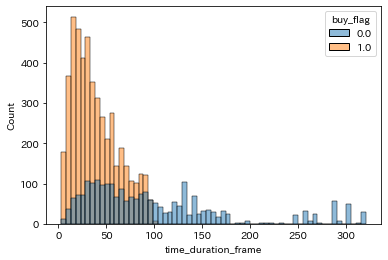

In [28]:
sns.histplot(data=df_train, x="time_duration_frame",hue="buy_flag")

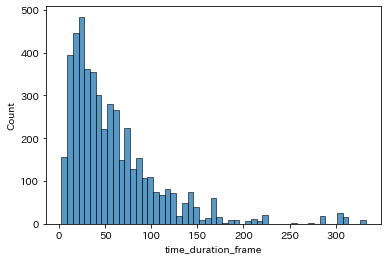

In [29]:
sns.histplot(data=df_test, x="time_duration_frame")

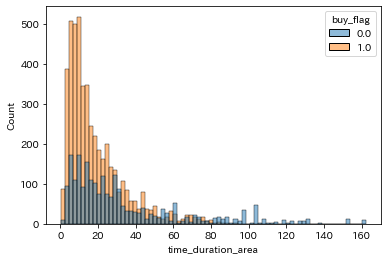

In [30]:
sns.histplot(data=df_train, x="time_duration_area",hue="buy_flag")

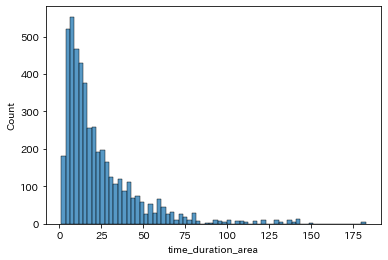

In [31]:
sns.histplot(data=df_test, x="time_duration_area")

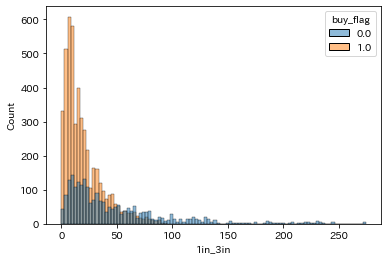

In [32]:
sns.histplot(data=df_train, x="1in_3in",hue="buy_flag")

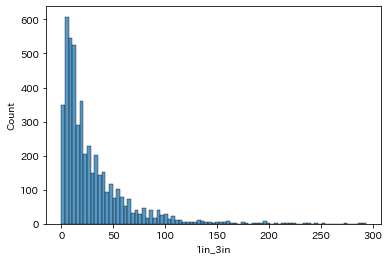

In [33]:
sns.histplot(data=df_test, x="1in_3in")

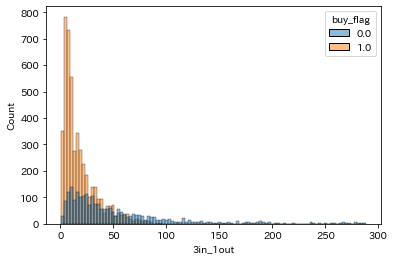

In [34]:
sns.histplot(data=df_train, x="3in_1out",hue="buy_flag")

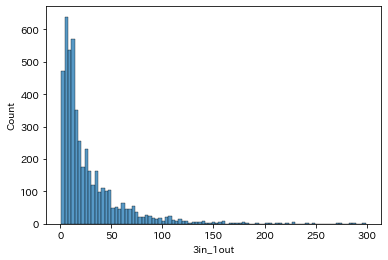

In [35]:
sns.histplot(data=df_test, x="3in_1out")

In [36]:
df_train.buy_flag.value_counts()

1.0    4827
0.0    2301
Name: buy_flag, dtype: int64

## 3-4.オーバーサンプリング

In [37]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,6.2,1.0,8
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,6.2,1.0,8
2,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.6,7.8,1.0,8
3,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,7.8,1.0,8
4,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.2,14.0,1.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7123,20201101-120054,6,man,30's,Young,うるうるグリーンティー525ml,525,エターナル,1.0,13,15,28.4,11.2,0.0,21
7124,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,13,14,28.4,11.2,0.0,21
7125,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,14,14,28.4,11.2,1.0,21
7126,20201101-120055,6,woman,30's,Young,ジャパンスプラッシュ500ml,500,クオリティー,5.0,6,7,14.0,13.0,0.0,21


In [38]:
adasyn = BorderlineSMOTE(random_state = CONFIG.seed)
#sample_cols=["1in_3in", "3in_1out","time_duration_frame","time_duration_area","in_time_hour","in_time_min"]
sample_cols=["time_duration_frame","time_duration_area"]

#対象カラムのオーバーサンプリング
X, y = adasyn.fit_resample(df_train[sample_cols], df_train['buy_flag'])
df_oversample = pd.DataFrame(X, columns = sample_cols)
df_oversample["buy_flag"]=y
add_samples=df_oversample.iloc[list(df_train.index)[-1]+1:]

#buy_flag=0のrow複製
add_nums = len(df_oversample)-len(df_train) 
sample_list = list(df_train[df_train.buy_flag==0].index)
over_items =random.choices(sample_list,k=add_nums)
add_df = df_train.loc[over_items]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [39]:
#オーバサンプリングした数値の上書き
add_nums = len(df_oversample)-len(df_train) 
sample_list = list(df_train[df_train.buy_flag==0].index)
over_items =random.choices(sample_list,k=add_nums)
add_df = df_train.loc[over_items]

In [40]:
for i in sample_cols:
  add_df[i]=add_samples[i].values

In [41]:
add_df

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour
2556,20201028-060156,2,man,60's,Senior,健康志向500ml,500,ラボラトリー,1.0,223,97,42.654426,33.945574,0.0,19
4829,20201031-020084,5,woman,30's,Young,ワイルドオレ500ml,500,ラボラトリー,1.0,30,32,41.080943,22.800000,0.0,11
88,20201026-010077,0,woman,50's,Middle,新緑の丘525ml,525,フューチャー,1.0,8,279,94.452653,17.909580,0.0,9
4245,20201030-050193,4,man,40's,Middle,ヨーグルトサイダー500ml,500,デイリーイースト,1.0,96,159,98.004541,22.962725,0.0,17
116,20201026-010077,0,woman,50's,Middle,新緑の丘525ml,525,フューチャー,1.0,108,178,77.400000,8.000000,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6464,20201101-070015,6,man,10's,Teen,ファイナルカード355ml,355,ゲーミングファイト,3.0,64,14,38.708983,16.381442,0.0,15
2764,20201029-010030,3,woman,40's,Middle,ウェットスポーツ500ml,500,トップモード,5.0,9,16,25.314788,11.486091,0.0,8
2794,20201029-010069,3,woman,40's,Middle,ヘルシーなお茶410ml,410,フューチャー,1.0,40,20,50.315184,40.676789,0.0,9
3735,20201030-020034,4,woman,40's,Middle,カフェインレス健康茶630ml,630,ネイティブ,1.0,20,24,50.293168,9.804969,0.0,11


In [42]:
df_train = pd.concat([df_train,add_df],axis=0).reset_index(drop=True)

In [43]:
df_train.buy_flag.value_counts()

0.0    4827
1.0    4827
Name: buy_flag, dtype: int64

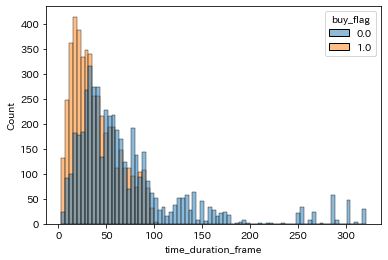

In [44]:
sns.histplot(data=df_train, x="time_duration_frame",hue="buy_flag")

In [45]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.200000,6.200000,1.0,8
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.200000,6.200000,1.0,8
2,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.600000,7.800000,1.0,8
3,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.600000,7.800000,1.0,8
4,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.200000,14.000000,1.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9649,20201101-070015,6,man,10's,Teen,ファイナルカード355ml,355,ゲーミングファイト,3.0,64,14,38.708983,16.381442,0.0,15
9650,20201029-010030,3,woman,40's,Middle,ウェットスポーツ500ml,500,トップモード,5.0,9,16,25.314788,11.486091,0.0,8
9651,20201029-010069,3,woman,40's,Middle,ヘルシーなお茶410ml,410,フューチャー,1.0,40,20,50.315184,40.676789,0.0,9
9652,20201030-020034,4,woman,40's,Middle,カフェインレス健康茶630ml,630,ネイティブ,1.0,20,24,50.293168,9.804969,0.0,11


## 3-5.Area外滞在時間/Area滞在時間率

In [46]:
df_train["time_frameout"] = df_train["time_duration_frame"] - df_train["time_duration_area"]
df_test["time_frameout"] = df_test["time_duration_frame"] - df_test["time_duration_area"]

In [47]:
df_train["time_area_rate"] = df_train["time_duration_area"] / df_train["time_duration_frame"]
df_test["time_area_rate"] = df_test["time_duration_area"] / df_test["time_duration_frame"]

In [48]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,time_frameout,time_area_rate
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.200000,6.200000,1.0,8,0.000000,1.000000
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.200000,6.200000,1.0,8,0.000000,1.000000
2,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.600000,7.800000,1.0,8,5.800000,0.573529
3,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.600000,7.800000,1.0,8,5.800000,0.573529
4,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.200000,14.000000,1.0,8,0.200000,0.985915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9649,20201101-070015,6,man,10's,Teen,ファイナルカード355ml,355,ゲーミングファイト,3.0,64,14,38.708983,16.381442,0.0,15,22.327541,0.423195
9650,20201029-010030,3,woman,40's,Middle,ウェットスポーツ500ml,500,トップモード,5.0,9,16,25.314788,11.486091,0.0,8,13.828697,0.453730
9651,20201029-010069,3,woman,40's,Middle,ヘルシーなお茶410ml,410,フューチャー,1.0,40,20,50.315184,40.676789,0.0,9,9.638395,0.808440
9652,20201030-020034,4,woman,40's,Middle,カフェインレス健康茶630ml,630,ネイティブ,1.0,20,24,50.293168,9.804969,0.0,11,40.488199,0.194956


## 3-6.ターゲットエンコーディング（購入率）

In [49]:
def target_encoding(df,df_1,col):

  rate_df=df_train.groupby(col).buy_flag.sum().reset_index().set_index(col)
  count_df=df_train.groupby(col).customer_id.count().reset_index().set_index(col)

  cvr_df=pd.concat([rate_df,count_df],axis=1)
  cvr_df["cvr_rate_"+str(col)]=cvr_df["buy_flag"] / cvr_df["customer_id"]
  cvr_df=cvr_df.drop(columns=["buy_flag","customer_id"])
  cvr_df=cvr_df.reset_index()

  df = pd.merge(df,cvr_df,on=col)
  df_1 = pd.merge(df_1,cvr_df,on=col)

  return df,df_1

In [50]:
target_cols=['event_day',
             'gender', 
             'age',
             'age_category',
             'product_name', 
             'size',
             'company',
             'area_id',
             'in_time_hour']

for col in target_cols:
  df_train,df_test=target_encoding(df_train,df_test,col)

In [51]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,time_frameout,time_area_rate,cvr_rate_event_day,cvr_rate_gender,cvr_rate_age,cvr_rate_age_category,cvr_rate_product_name,cvr_rate_size,cvr_rate_company,cvr_rate_area_id,cvr_rate_in_time_hour
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,6.2,1.0,8,0.0,1.000000,0.534258,0.492186,0.581528,0.596212,0.763699,0.562641,0.633894,0.525978,0.495851
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,6.2,1.0,8,0.0,1.000000,0.534258,0.492186,0.581528,0.596212,0.763699,0.562641,0.633894,0.525978,0.495851
2,20201027-010002,1,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,17,2,19.4,8.2,1.0,8,11.2,0.422680,0.474447,0.492186,0.581528,0.596212,0.763699,0.562641,0.633894,0.525978,0.495851
3,20201027-010049,1,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,12,30,43.0,7.8,1.0,8,35.2,0.181395,0.474447,0.492186,0.581528,0.596212,0.763699,0.562641,0.633894,0.525978,0.495851
4,20201026-010050,0,man,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,16,7,23.8,12.2,1.0,8,11.6,0.512605,0.534258,0.509058,0.581528,0.596212,0.763699,0.562641,0.633894,0.525978,0.495851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9649,20201101-070133,6,man,50's,Middle,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,20,20,40.6,24.4,1.0,15,16.2,0.600985,0.522829,0.509058,0.603026,0.540296,0.168539,0.249027,0.274194,0.464342,0.455682
9650,20201028-040036,2,woman,40's,Middle,ハードコア120ml,120,トップモード,2.0,64,26,91.4,3.8,0.0,15,87.6,0.041575,0.515254,0.492186,0.490212,0.540296,0.189189,0.189189,0.442308,0.464342,0.455682
9651,20201031-040037,5,woman,30's,Young,水玉ウォーター500ml,500,カルシウムウェイ,2.0,12,10,22.6,4.2,1.0,15,18.4,0.185841,0.424681,0.492186,0.581528,0.596212,0.377358,0.525148,0.377358,0.464342,0.455682
9652,20201101-070012,6,man,50's,Middle,キッズアップル470ml,470,オールフロント,2.0,9,48,57.2,5.6,0.0,15,51.6,0.097902,0.522829,0.509058,0.603026,0.540296,0.051447,0.125249,0.071429,0.464342,0.455682


In [52]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time_hour,time_frameout,time_area_rate,cvr_rate_event_day,cvr_rate_gender,cvr_rate_age,cvr_rate_age_category,cvr_rate_product_name,cvr_rate_size,cvr_rate_company,cvr_rate_area_id,cvr_rate_in_time_hour
0,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8.0,11.0,19.8,7.2,8,12.6,0.363636,0.534258,0.509058,0.490212,0.540296,0.899083,0.562641,0.633894,0.525978,0.495851
1,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10.0,9.0,19.8,7.2,8,12.6,0.363636,0.534258,0.509058,0.490212,0.540296,0.899083,0.562641,0.633894,0.525978,0.495851
2,20201029-010002,3,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10.0,4.0,14.4,5.2,8,9.2,0.361111,0.528870,0.509058,0.490212,0.540296,0.899083,0.562641,0.633894,0.525978,0.495851
3,20201030-010007,4,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8.0,10.0,18.4,7.2,8,11.2,0.391304,0.523589,0.509058,0.490212,0.540296,0.899083,0.562641,0.633894,0.525978,0.495851
4,20201030-010007,4,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10.0,8.0,18.4,7.2,8,11.2,0.391304,0.523589,0.509058,0.490212,0.540296,0.899083,0.562641,0.633894,0.525978,0.495851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4843,20201101-050032,6,woman,40's,Middle,黒の息吹500ml,500,モーリーフラフト,2.0,51.0,13.0,64.8,37.8,13,27.0,0.583333,0.522829,0.492186,0.490212,0.540296,0.416667,0.525148,0.274194,0.464342,0.570300
4844,20201101-050032,6,woman,40's,Middle,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,44.0,20.0,64.8,37.8,13,27.0,0.583333,0.522829,0.492186,0.490212,0.540296,0.168539,0.249027,0.274194,0.464342,0.570300
4845,20201029-030110,3,woman,30's,Young,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,36.0,13.0,50.0,35.8,13,14.2,0.716000,0.528870,0.492186,0.581528,0.596212,0.168539,0.249027,0.274194,0.464342,0.570300
4846,20201031-030018,5,woman,30's,Young,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,14.0,11.0,25.8,10.8,13,15.0,0.418605,0.424681,0.492186,0.581528,0.596212,0.168539,0.249027,0.274194,0.464342,0.570300


## 3-7. カテゴリーの特徴量の変換

In [53]:
# BaseBlock
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()
        
# CountEncoding
class CountEncoding(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        self.encoder = ce.CountEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.encoder.transform(input_df[self.cols]).add_prefix("CE_")

# OrdinalEncoding
class OrdinalEncoding(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OrdinalEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OE_")

In [54]:
def get_ce_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time_hour',
            #'in_time_min',
            'product_name', 
            'size', 
            'company']
    encoder = CountEncoding(cols = cols)
    output_df = encoder.fit(_input_df.astype(str))
    return output_df


def get_oe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time_hour',
            #'in_time_min',
            'product_name', 
            'size', 
            'company']
    encoder = OrdinalEncoding(cols = cols)
    output_df = encoder.fit(_input_df)
    return output_df

In [55]:
df_train_ce=get_ce_features(df_train)
df_train_oe=get_oe_features(df_train)

df_test_ce=get_ce_features(df_test)
df_test_oe=get_oe_features(df_test)

In [56]:
target = df_train["buy_flag"]
df_train_encoded = df_train.drop(columns=['gender','age','age_category', 'event_day', 'area_id','in_time_hour','product_name', 'size', 'company',"buy_flag"])
df_train_encoded = pd.concat([df_train_encoded,df_train_ce,df_train_oe],axis=1)
df_train_encoded["buy_flag"] = target 

df_test_encoded = df_test.drop(columns=['gender','age','age_category', 'event_day', 'area_id','in_time_hour','product_name', 'size', 'company'])
df_test_encoded = pd.concat([df_test_encoded,df_test_ce,df_test_oe],axis=1)

# 4.モデル作成　(Light GBM)

In [57]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [58]:
def fit_lgbm(X, y, cv, params: dict=None, verbose: int=50):
    
    metric_func = roc_auc_score
    
    if params is None:
        params = {}

    models = []
    
    # training data の target と同じだけのゼロ配列を用意
    #oof_pred_df = pd.DataFrame(np.zeros_like(train_y, dtype=np.float)).rename(columns={0:"pred"})
    oof_pred_df = pd.DataFrame()

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # 交差検証 データセットを cv instance によって分割
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMClassifier(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)

        pred = clf.predict_proba(x_valid)[:, 1]
        pred_bool = clf.predict(x_valid)

        print(f'AUC {i} Score: {metric_func(y_valid, pred) :.4f}')
        
        oof_fold_df = pd.DataFrame(np.zeros_like(y_valid, dtype=np.float)).rename(columns={0:"pred"})
        oof_fold_df["id"]=idx_valid
        oof_fold_df["fold"]=i+1
        oof_fold_df["pred_prob"] = pred
        oof_fold_df["pred_bool"] = pred_bool
        
        oof_pred_df=pd.concat([oof_pred_df,oof_fold_df],axis=0)
        
        
        models.append(clf)
        
    oof_pred_df=oof_pred_df.sort_values("id").reset_index(drop=True).set_index("id").reindex(['fold', 'y', 'pred_prob','pred_bool'], axis='columns')
    oof_pred_df["y"]=y
    score = metric_func(y, oof_pred_df["pred_prob"]) 
    print('FINISHED | AUC Score: {:.4f}'.format(score))
    return oof_pred_df, models

## 4-1.学習

In [75]:
params = {
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'objective': "binary",
    'class_weight':"balanced",
    'max_depth': 10,
    "random_state":CONFIG.seed
    }

fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
cv = list(fold.split(df_train_encoded, df_train_encoded["buy_flag"]))

train_x=df_train_encoded.drop(columns=["customer_id"])
train_x = train_x.iloc[:,:-1]
train_y = df_train_encoded["buy_flag"]


oof, models = fit_lgbm(train_x.values, train_y, cv, params=params)

Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.552225
[100]	valid_0's binary_logloss: 0.483029
[150]	valid_0's binary_logloss: 0.44361
[200]	valid_0's binary_logloss: 0.418655
[250]	valid_0's binary_logloss: 0.402414
[300]	valid_0's binary_logloss: 0.392472
[350]	valid_0's binary_logloss: 0.385385
[400]	valid_0's binary_logloss: 0.378567
[450]	valid_0's binary_logloss: 0.373823
[500]	valid_0's binary_logloss: 0.369527
[550]	valid_0's binary_logloss: 0.365352
[600]	valid_0's binary_logloss: 0.361782
[650]	valid_0's binary_logloss: 0.358641
[700]	valid_0's binary_logloss: 0.356155
[750]	valid_0's binary_logloss: 0.353979
[800]	valid_0's binary_logloss: 0.351795
[850]	valid_0's binary_logloss: 0.348151
[900]	valid_0's binary_logloss: 0.345004
[950]	valid_0's binary_logloss: 0.342937
[1000]	valid_0's binary_logloss: 0.340935
[1050]	valid_0's binary_logloss: 0.339254
[1100]	valid_0's binary_logloss: 0.3378
[1150]	valid_0's binary_logloss: 0.33

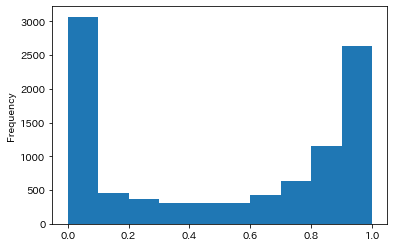

In [60]:
oof["pred_prob"].plot(kind="hist")

## 4-2.学習結果

In [61]:
#特徴量の可視化
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
        CVごとのブレを boxen plot として表現.
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(10, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='Blues_d', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig, ax

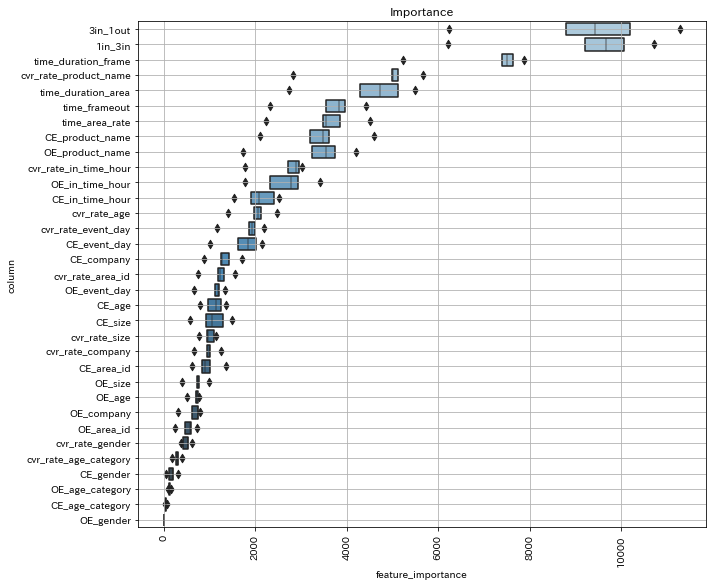

In [62]:
fig, ax = visualize_importance(models, train_x)

In [63]:
#ROCカーブの可視化
def visulalize_roc(df, fold):
    """各foldおよび出力平均のROCカーブを描画する

    args:
        df:出力oof df
        fold: fold数
    """
    
    fig = plt.figure(figsize=[8,8])
    
    tprs = []
    aucs = []
    
    mean_fpr = np.linspace(0,1,100)
    
    i = 1
    
    folds = list(range(1,fold+1))
    

    for v in folds:
        
        df_tmp = df[df.fold==v]
        fpr, tpr, t = roc_curve(df_tmp["y"], df_tmp["pred_prob"])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
        i= i+1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")

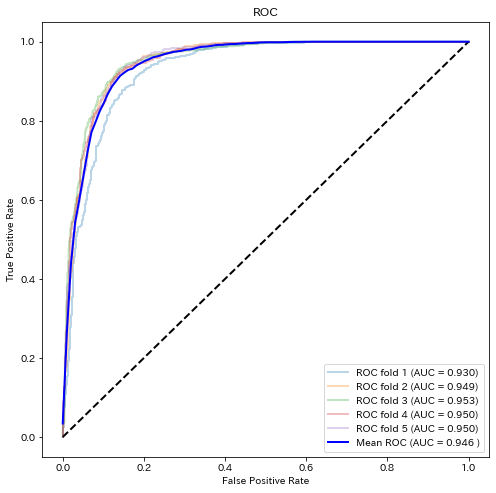

In [64]:
visulalize_roc(oof,CONFIG.fold)

In [65]:
#混合行列の可視化
def visualize_confusion_matrix(y_true,pred_label,height=.6,labels=None):
    
    """
    混合行列をプロットする
    """
    
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

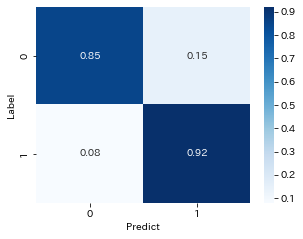

In [66]:
visualize_confusion_matrix(y_true=oof.y,pred_label=oof.pred_bool)

## 4-3.推論

In [67]:
df_index = df_test_encoded["customer_id"]
df_test_pred = df_test_encoded.iloc[:,1:]

pred = np.array([model.predict_proba(df_test_pred.values) for model in models])
pred = np.mean(pred, axis=0)[:, 1]

In [68]:
submission_pred = pd.DataFrame()
submission_pred["customer_id"] = df_index
submission_pred["buy_proba"] = pred

In [69]:
submission_pred = submission_pred.groupby("customer_id").max()

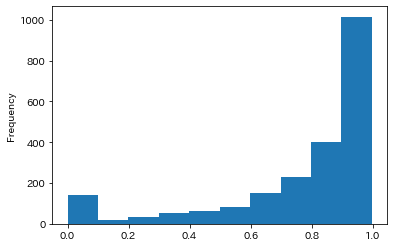

In [70]:
submission_pred["buy_proba"].plot(kind="hist")

In [71]:
submission_pred_0 = pd.DataFrame()
submission_pred_0["customer_id"] = df_test_0["customer_id"]
submission_pred_0["buy_proba"] = 0
submission_pred_0 = submission_pred_0.drop_duplicates()
submission_pred_0=submission_pred_0.set_index("customer_id")

others_list=set(list(submission_pred.index)) ^ set(list(submission_pred_0.index)) 
submission_pred_0 = submission_pred_0.loc[others_list]

In [72]:
submission_pred_all = pd.concat([submission_pred,submission_pred_0],axis=0).reset_index().sort_values("customer_id").reset_index(drop=True)

In [73]:
submission_pred_all

,customer_id,buy_proba
0,20201026-010006,0.985436
1,20201026-010008,0.870974
2,20201026-010011,0.925070
3,20201026-010012,0.987648
4,20201026-010018,0.510851
...,...,...
4525,20201101-120039,0.000000
4526,20201101-120046,0.000000
4527,20201101-120051,0.000000
4528,20201101-120052,0.846288


In [74]:
submission_pred_all.to_csv(output_dir + CONFIG.exp+ "_submission.csv",index=False)